In [88]:
import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install -U spacy
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install dill

# !{sys.executable} -m pip install wordcloud

In [2]:
# Run in python console
import re
import os
import numpy as np
import pandas as pd
import random
import dill

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk; nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [3]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [4]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [5]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)

In [6]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")


4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [7]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [8]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [9]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [10]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [11]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [12]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [13]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [14]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27107, 47))

In [15]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [16]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [17]:
lst_texts = generate_list_content(df_model_en_desc)

In [18]:
len(lst_texts)

27107

## Tokenize words and clean up text

In [19]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [22]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [23]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [24]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

# num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
num_topics = [2,3,4,5,6,7,8,9,10]
models = build_topics(num_topics)

In [25]:
## Saving the models to disc
from gensim.test.utils import datapath

# Save model to disk.
for i in range(len(models)):
    temp_file = datapath("model" + str(i))
    models[i].save(temp_file)

In [26]:
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) "Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample".

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [27]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [28]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.717424,0.451804,2
1,-6.696299,0.473099,3
2,-6.710002,0.468125,4
3,-6.717901,0.481640,5
4,-6.738010,0.485963,6
5,-6.769764,0.431352,7
6,-6.802776,0.430377,8
7,-6.855112,0.461478,9
8,-6.948241,0.473357,10


## Graphic of number of Topics and Perplexity

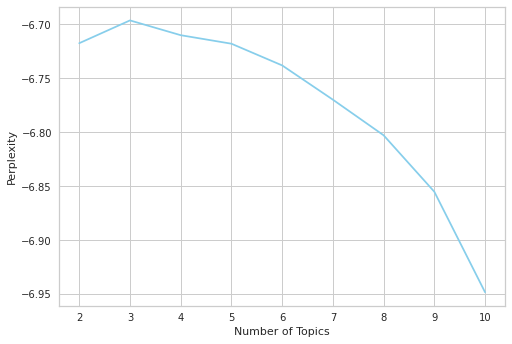

In [29]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

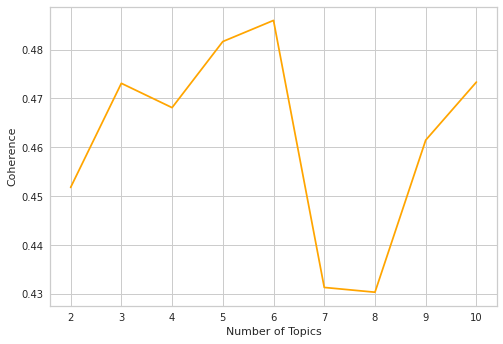

In [30]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics according to the best *n*

### Visualization with 5 topics

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[3], corpus, id2word, sort_topics=False)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      19.253855        1       1 -0.070009  0.254804
1      29.501667        1       2 -0.154434 -0.297339
2      23.997950        1       3 -0.218865  0.124887
3      23.438461        1       4  0.090392 -0.107863
4       3.808067        1       5  0.352915  0.025510, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
99    Default  41075.000000         room  41075.000000  30.0000  30.0000
141   Default  19701.000000         walk  19701.000000  29.0000  29.0000
96    Default  20010.000000      private  20010.000000  28.0000  28.0000
106   Default  19153.000000        train  19153.000000  27.0000  27.0000
289   Default  12466.000000         stay  12466.000000  26.0000  26.0000
110   Default  45053.000000    apartment  45053.000000  25.0000  25.0000
93    Default  18317.000000       minute  18317.000000  24.0000  24.0000
8     Default  19494.000000          bed  19494.000000  23.0000  23.0000
218   Default  16755.000000   restaurant  16755.000000  22.0000  22.0000
62    Default  13936.000000     bathroom  13936.000000  21.0000  21.0000
182   Default  10587.000000        share  10587.000000  20.0000  20.0000
198   Default  13927.000000         away  13927.000000  19.0000  19.0000
19    Default  11700.000000        floor  11700.000000  18.0000  18.0000
87    Default  16486.000000        guest  16486.000000  17.0000  17.0000
63    Default  28645.000000      bedroom  28645.000000  16.0000  16.0000
175   Default  10096.000000        place  10096.000000  15.0000  15.0000
64    Default  11796.000000        block  11796.000000  14.0000  14.0000
137   Default  11100.000000       subway  11100.000000  13.0000  13.0000
127   Default  10499.000000       living  10499.000000  12.0000  12.0000
201   Default   3812.000000        check   3812.000000  11.0000  11.0000
309   Default  12118.000000         home  12118.000000  10.0000  10.0000
202   Default  10281.000000        close  10281.000000   9.0000   9.0000
228   Default   9577.000000          bar   9577.000000   8.0000   8.0000
366   Default   8611.000000        clean   8611.000000   7.0000   7.0000
185   Default  15992.000000        space  15992.000000   6.0000   6.0000
20    Default  12788.000000         full  12788.000000   5.0000   5.0000
28    Default  11707.000000      kitchen  11707.000000   4.0000   4.0000
381   Default   5757.000000      provide   5757.000000   3.0000   3.0000
239   Default   6656.000000        fully   6656.000000   2.0000   2.0000
37    Default   6430.000000       modern   6430.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
990    Topic5    311.177948      general    312.075470   3.2652  -5.3889
590    Topic5    293.750122         date    294.643646   3.2650  -5.4465
1684   Topic5    280.850037        prior    281.731140   3.2649  -5.4914
2977   Topic5    299.502747      monitor    300.456482   3.2649  -5.4271
1051   Topic5    276.986267       ensure    277.883453   3.2648  -5.5053
4341   Topic5    264.357269      ability    265.223755   3.2648  -5.5519
1595   Topic5    269.576172    exception    270.464905   3.2648  -5.5324
178    Topic5    271.279449         rate    272.180237   3.2647  -5.5261
1802   Topic5    269.763153      sparkle    270.664307   3.2647  -5.5317
1746   Topic5    390.873596         deep    394.122498   3.2598  -5.1609
855    Topic5    715.671997          run   1105.873779   2.8329  -4.5560
289    Topic5   2523.322510         stay  12466.949219   1.6705  -3.2959
2794   Topic5    569.680359    essential   1116.624146   2.5951  -4.7842
366    Topic5   1416.100708        clean   8611.476562   1.4629  -3.8736
500    Topic5    869.296875         text   3195.670166   1.9662  -4.3616
174    Topic5    710.165771       person   2209.884766   2.1329  -4.5637
16

In [32]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

### Visualization with 7 topics

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[5], corpus, id2word, sort_topics=False)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      13.402764        1       1  0.120997 -0.288130
1      19.547920        1       2  0.139429  0.233416
2      21.936464        1       3  0.172610 -0.127163
3      23.385454        1       4  0.116203  0.257912
4       1.089622        1       5 -0.331752 -0.009141
5       1.116496        1       6 -0.333926  0.002101
6      19.521275        1       7  0.116440 -0.068996, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
99    Default  40650.000000          room  40650.000000  30.0000  30.0000
110   Default  46114.000000     apartment  46114.000000  29.0000  29.0000
63    Default  29567.000000       bedroom  29567.000000  28.0000  28.0000
96    Default  19982.000000       private  19982.000000  27.0000  27.0000
141   Default  19835.000000          walk  19835.000000  26.0000  26.0000
106   Default  19281.000000         train  19281.000000  25.0000  25.0000
93    Default  18440.000000        minute  18440.000000  24.0000  24.0000
8     Default  20244.000000           bed  20244.000000  23.0000  23.0000
182   Default  10477.000000         share  10477.000000  22.0000  22.0000
87    Default  16408.000000         guest  16408.000000  21.0000  21.0000
289   Default  12532.000000          stay  12532.000000  20.0000  20.0000
198   Default  14021.000000          away  14021.000000  19.0000  19.0000
62    Default  13985.000000      bathroom  13985.000000  18.0000  18.0000
218   Default  17010.000000    restaurant  17010.000000  17.0000  17.0000
20    Default  13162.000000          full  13162.000000  16.0000  16.0000
64    Default  11875.000000         block  11875.000000  15.0000  15.0000
137   Default  11175.000000        subway  11175.000000  14.0000  14.0000
309   Default  12022.000000          home  12022.000000  13.0000  13.0000
202   Default  10346.000000         close  10346.000000  12.0000  12.0000
19    Default  11468.000000         floor  11468.000000  11.0000  11.0000
249   Default  12817.000000  neighborhood  12817.000000  10.0000  10.0000
131   Default   8559.000000         queen   8559.000000   9.0000   9.0000
127   Default  10668.000000        living  10668.000000   8.0000   8.0000
28    Default  11906.000000       kitchen  11906.000000   7.0000   7.0000
136   Default   8113.000000       station   8113.000000   6.0000   6.0000
134   Default   7973.000000          size   7973.000000   5.0000   5.0000
381   Default   5792.000000       provide   5792.000000   4.0000   4.0000
113   Default   6950.000000      building   6950.000000   3.0000   3.0000
366   Default   8748.000000         clean   8748.000000   2.0000   2.0000
175   Default   9895.000000         place   9895.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
967    Topic7   1066.018066          meet   1066.938599   1.6328  -5.7919
357    Topic7   1062.916748          sure   1063.837646   1.6328  -5.7948
922    Topic7   1040.637207         party   1041.558350   1.6328  -5.8160
432    Topic7   1038.129150         happy   1039.049561   1.6328  -5.8184
349    Topic7   1013.037292          read   1013.958313   1.6328  -5.8429
559    Topic7    976.042236           try    976.962524   1.6327  -5.8801
477    Topic7    934.836182         there    935.756836   1.6327  -5.9232
368    Topic7   3682.562988           day   3686.213379   1.6327  -4.5523
618    Topic7   2794.937012           may   2797.888184   1.6326  -4.8281
156    Topic7   2567.412598          give   2580.522217   1.6286  -4.9130
387    Topic7   2871.023438          will   2954.106689   1.6051  -4.8012
193    Topic7   1734.322998         visit   1759.295654   1.6194  -5.3052
309    Topic7  10623.791992          home  12022.035156   1.5100  -3.4928
464    Topic7   2417.931152          help   2531.926758   1.5876  -

In [34]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

### Visualization with 9 topics 

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[7], corpus, id2word, sort_topics=False)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       6.887641        1       1 -0.065353  0.263702
1      19.922108        1       2 -0.169901 -0.012538
2       1.151196        1       3  0.289117 -0.072598
3      25.077375        1       4 -0.171837 -0.159997
4       0.698111        1       5  0.284985 -0.059245
5       2.441115        1       6  0.214443  0.092943
6      15.565373        1       7 -0.131230  0.120293
7      13.950455        1       8 -0.125671  0.138190
8      14.306624        1       9 -0.124554 -0.310750, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
99    Default  41019.000000          room  41019.000000  30.0000  30.0000
63    Default  28651.000000       bedroom  28651.000000  29.0000  29.0000
96    Default  20291.000000       private  20291.000000  28.0000  28.0000
8     Default  19753.000000           bed  19753.000000  27.0000  27.0000
141   Default  19876.000000          walk  19876.000000  26.0000  26.0000
182   Default  10252.000000         share  10252.000000  25.0000  25.0000
87    Default  16973.000000         guest  16973.000000  24.0000  24.0000
106   Default  19323.000000         train  19323.000000  23.0000  23.0000
93    Default  18479.000000        minute  18479.000000  22.0000  22.0000
110   Default  45302.000000     apartment  45302.000000  21.0000  21.0000
218   Default  16904.000000    restaurant  16904.000000  20.0000  20.0000
366   Default   8667.000000         clean   8667.000000  19.0000  19.0000
289   Default  12830.000000          stay  12830.000000  18.0000  18.0000
20    Default  12724.000000          full  12724.000000  17.0000  17.0000
309   Default  12551.000000          home  12551.000000  16.0000  16.0000
198   Default  14051.000000          away  14051.000000  15.0000  15.0000
175   Default  10338.000000         place  10338.000000  14.0000  14.0000
185   Default  16141.000000         space  16141.000000  13.0000  13.0000
28    Default  11750.000000       kitchen  11750.000000  12.0000  12.0000
127   Default  10732.000000        living  10732.000000  11.0000  11.0000
390   Default  10933.000000        access  10933.000000  10.0000  10.0000
19    Default  11174.000000         floor  11174.000000   9.0000   9.0000
64    Default  11900.000000         block  11900.000000   8.0000   8.0000
129   Default   8207.000000           new   8207.000000   7.0000   7.0000
249   Default  12705.000000  neighborhood  12705.000000   6.0000   6.0000
137   Default  11199.000000        subway  11199.000000   5.0000   5.0000
202   Default  10368.000000         close  10368.000000   4.0000   4.0000
62    Default  14057.000000      bathroom  14057.000000   3.0000   3.0000
113   Default   7242.000000      building   7242.000000   2.0000   2.0000
228   Default   9662.000000           bar   9662.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
65     Topic9   1297.372070    brownstone   1298.327637   1.9437  -5.2847
1456   Topic9   1149.388428         prime   1150.344360   1.9436  -5.4059
22     Topic9   1077.562500      gorgeous   1078.518188   1.9436  -5.4704
306    Topic9   1066.159790          foot   1067.115479   1.9436  -5.4810
775    Topic9   1046.772461      recently   1047.728394   1.9435  -5.4994
11     Topic9    994.043823     centrally    994.999756   1.9435  -5.5511
585    Topic9    962.088928        unique    963.044678   1.9435  -5.5837
802    Topic9    945.572021      decorate    946.527954   1.9434  -5.6010
365    Topic9    931.985779         charm    932.941467   1.9434  -5.6155
797    Topic9    900.072083          wall    901.027832   1.9434  -5.6504
113    Topic9   7100.028809      building   7242.826172   1.9245  -3.5850
52     Topic9   5116.244629        studio   5217.048340   1.9249  -3.9127
120    Topic9   1935.399292      

In [36]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [37]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [38]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[3], corpus=corpus, texts=lst_texts)

In [39]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(2, 0.6513645)","(1, 0.15933967)","(0, 0.14275709)","(3, 0.04232766)",None
1,3831.0,"(2, 0.5715323)","(3, 0.16086411)","(1, 0.1330966)","(0, 0.12980285)",None
2,5099.0,"(2, 0.40627474)","(1, 0.35802507)","(0, 0.18117303)","(3, 0.05050937)",None
3,5121.0,"(3, 0.42289096)","(0, 0.25152218)","(4, 0.16013224)","(2, 0.092125036)","(1, 0.073329605)"
4,5178.0,"(0, 0.45221373)","(1, 0.20836571)","(2, 0.15486482)","(3, 0.11373003)","(4, 0.07082574)"


In [40]:
sent_topics_df.shape

(27857, 6)

In [41]:
sent_topics_df = sent_topics_df.dropna()

In [42]:
sent_topics_df.shape

(15807, 6)

### Separating the Topic from its score

In [43]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [44]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,"(3, 0.42289096)","(0, 0.25152218)","(4, 0.16013224)","(2, 0.092125036)","(1, 0.073329605)",3,0.422891,0,0.251522,4,0.160132,2,0.092125,1,0.073330
4,5178.0,"(0, 0.45221373)","(1, 0.20836571)","(2, 0.15486482)","(3, 0.11373003)","(4, 0.07082574)",0,0.452214,1,0.208366,2,0.154865,3,0.113730,4,0.070826
5,5238.0,"(1, 0.48411116)","(3, 0.17789896)","(2, 0.13463466)","(4, 0.12747219)","(0, 0.07588301)",1,0.484111,3,0.177899,2,0.134635,4,0.127472,0,0.075883
6,5441.0,"(3, 0.29044312)","(1, 0.2738606)","(0, 0.2379844)","(2, 0.14824699)","(4, 0.049464844)",3,0.290443,1,0.273861,0,0.237984,2,0.148247,4,0.049465
7,5552.0,"(1, 0.3636814)","(2, 0.30897036)","(3, 0.23114897)","(0, 0.04908644)","(4, 0.047112856)",1,0.363681,2,0.308970,3,0.231149,0,0.049086,4,0.047113


In [45]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [46]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,3,0.422891,0,0.251522,4,0.160132,2,0.092125,1,0.073330
4,5178.0,0,0.452214,1,0.208366,2,0.154865,3,0.113730,4,0.070826
5,5238.0,1,0.484111,3,0.177899,2,0.134635,4,0.127472,0,0.075883
6,5441.0,3,0.290443,1,0.273861,0,0.237984,2,0.148247,4,0.049465
7,5552.0,1,0.363681,2,0.308970,3,0.231149,0,0.049086,4,0.047113


In [47]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [48]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
3,5121.0,3,0.422891,0,0.251522,4,0.160132,2,0.092125,1,0.073330
4,5178.0,0,0.452214,1,0.208366,2,0.154865,3,0.113730,4,0.070826
5,5238.0,1,0.484111,3,0.177899,2,0.134635,4,0.127472,0,0.075883
6,5441.0,3,0.290443,1,0.273861,0,0.237984,2,0.148247,4,0.049465
7,5552.0,1,0.363681,2,0.308970,3,0.231149,0,0.049086,4,0.047113


## Modeling

In [49]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [50]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [51]:
df_model_en_desc_merged.shape

(27107, 57)

In [52]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [53]:
df_model_en_desc_merged.shape

(15807, 57)

### Understanding the topic that appears as winner the most

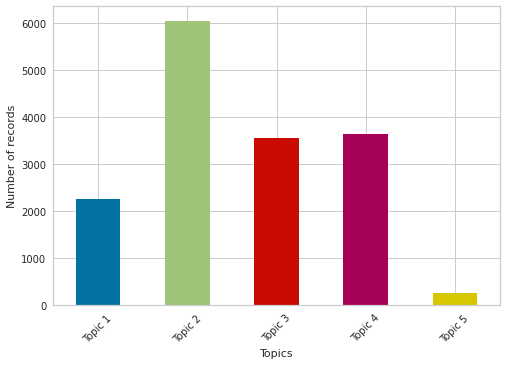

In [54]:
fig, ax = plt.subplots()
df = df_model_en_desc_merged.groupby('winner_topic').size().plot(kind='bar', x='topics', ax=ax)
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Topic 1'
labels[1] = 'Topic 2'
labels[2] = 'Topic 3'
labels[3] = 'Topic 4'
labels[4] = 'Topic 5'

ax.set_xticklabels(labels,rotation='45')
ax.set(xlabel='Topics', ylabel='Number of records')

plt.show()

The above plot si a representation of the distribution of the topics as the first option for each docuement.

at this plot we can conclude tha the topic that appear to be more latent in the corpus is the green bar that corresponds to topic 2 and the less prevalent is topic4. Let's now take a more thorough look at the words that are in each topic to have a better understanding of wht might be happening.

### Word Clouds

In [93]:
num_topics = 5
topic_words = []
for i in range(num_topics):
    tt = models[3].get_topic_terms(i,20)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [56]:
models[3].show_topic(0)

[('room', 0.1192315),
 ('private', 0.04971664),
 ('bed', 0.04166477),
 ('bathroom', 0.03519228),
 ('share', 0.030730719),
 ('guest', 0.028307565),
 ('living', 0.025656648),
 ('bedroom', 0.025530174),
 ('kitchen', 0.021200348),
 ('full', 0.019278405)]

In [94]:
df_top_30_n_5 = pd.DataFrame.from_records(topic_words)
df_top_30_n_5 = df_top_30_n_5.T

In [58]:
df_top_30_n_5.rename(columns={0: "Topic 1", 1: "Topic 2",
                              2: "Topic 3", 3: "Topic 4",
                              4: "Topic 5"}, inplace=True)

In [59]:
df_top_30_n_5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,room,apartment,apartment,place,check
1,private,walk,bedroom,home,stay
2,bed,train,floor,stay,book
3,bathroom,minute,large,need,list
4,share,restaurant,new,space,clean
5,guest,away,modern,guest,space
6,living,block,full,make,pm
7,bedroom,subway,renovate,feel,guest
8,kitchen,locate,fully,city,time
9,full,close,high,also,read


In [115]:
top_0 = models[3].show_topic(0, 30)
top_1 = models[3].show_topic(1, 30)
top_2 = models[3].show_topic(2, 30)
top_3 = models[3].show_topic(3, 30)
top_4 = models[3].show_topic(4, 30)

In [116]:
def listtodict(A, di):
    di = dict(A)
    return di 

di_wc_0 = listtodict(top_0,{})
di_wc_1 = listtodict(top_1,{})
di_wc_2 = listtodict(top_2,{})
di_wc_3 = listtodict(top_3,{})
di_wc_4 = listtodict(top_4,{})

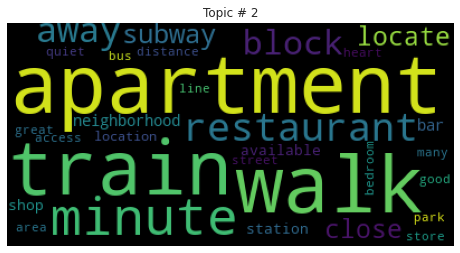

In [118]:
plt.figure()
plt.imshow(WordCloud().fit_words(di_wc_1))
plt.axis("off")
plt.title("Topic # 2")
plt.show()

It seems that Topic 2 has words related to location, for example: walk, train, neighborhood, block, close. This may lead to conclude that the majority of hosts recognize the importance of including such words into their description to attract guests. However, lets see if these words are actually influencing price. For this purpose we will try to understand the importance of each one of these topics' scores in our regression problem. We assume that the larger the impact of the score of each topic in the corpus, the most important to determine its price.

### Creating features X

In [60]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [61]:
y = df_model_en_desc_merged.price

### Cross validation with multiple regressors

In [62]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

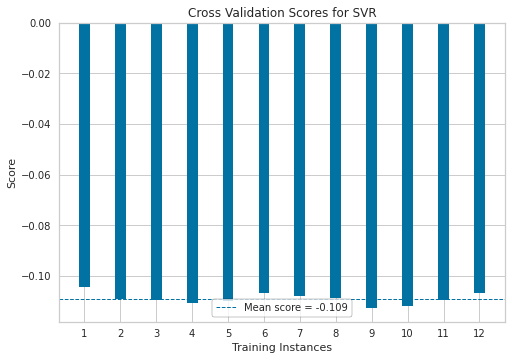

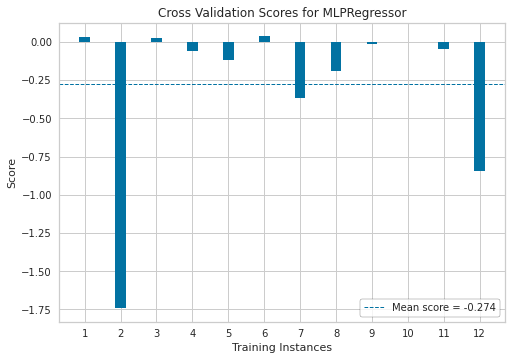

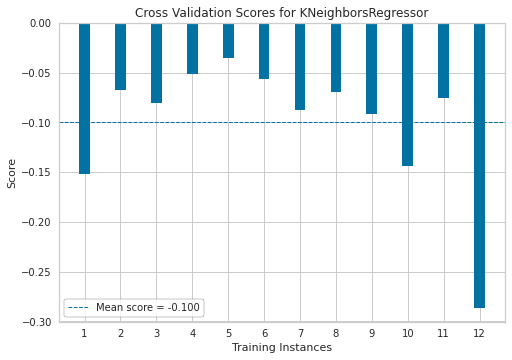

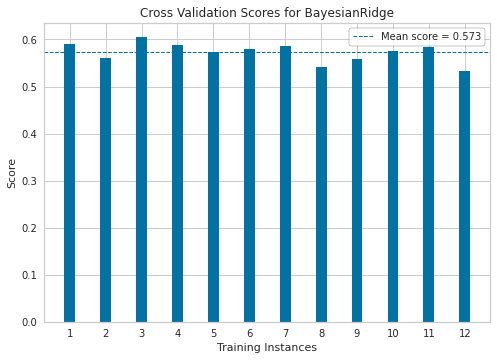

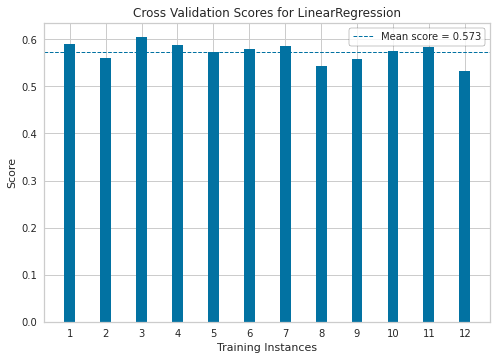

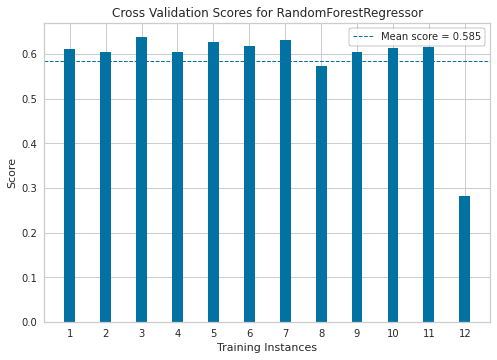

In [63]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Residuals for multiple regression models

### Split train - test sets

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

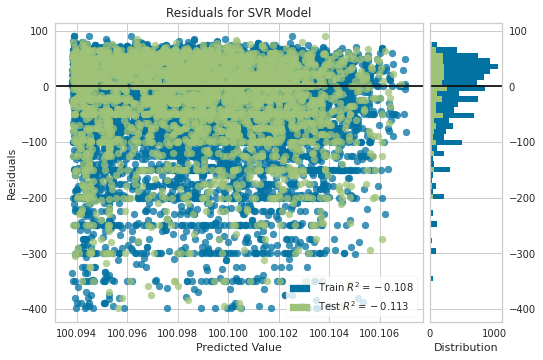

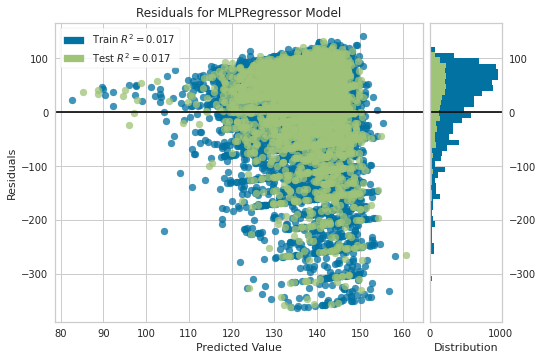

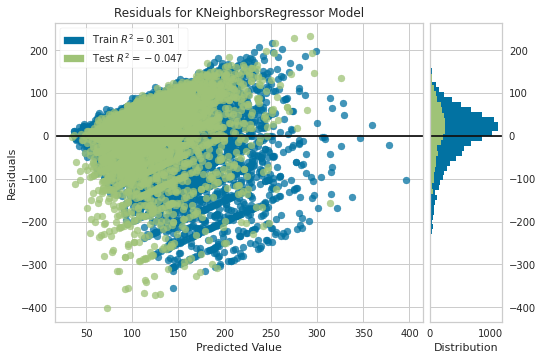

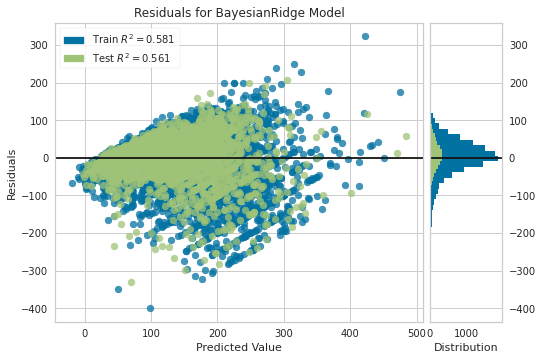

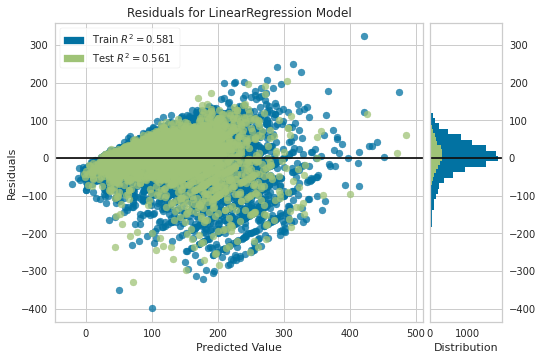

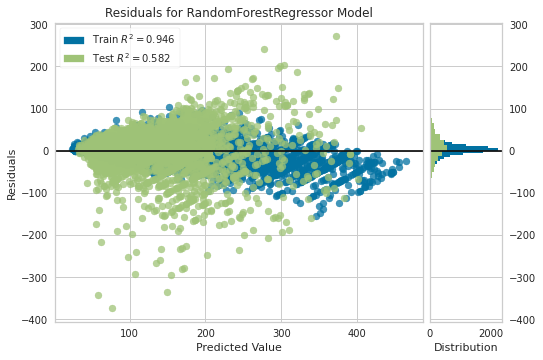

In [65]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

After analyzing the average score in cross validations together with the residuals, we can continue to conclude that our baseline model is still the Random Forest Regressor. This excercise was fundamental to see that despite the addition of information about the description, this continues to be true. We will now continue doing some more experimentation.

## Experimenting with the baseline model using the Random Forest Regressor

Random Forest algorithms are ensemble methods of decision trees generated on a random split of a determined data set.The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In the case of regression, the average of all the tree outputs is considered as the final result. Source: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [66]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [67]:
# making sure that the number of columns match with the features
X_train.shape, len(features), y_train.shape

((12645, 53), 53, (12645,))

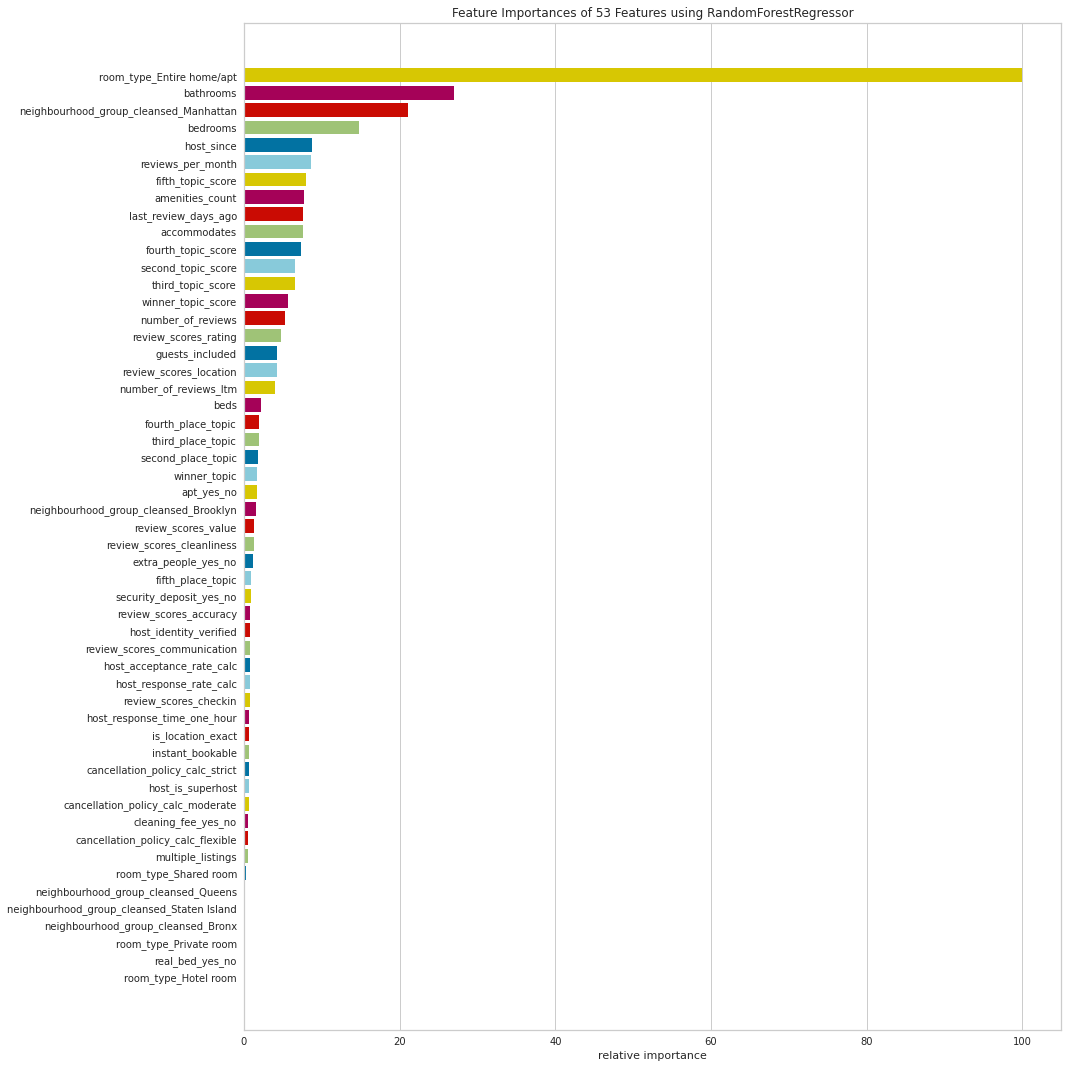

In [68]:
# Most important features
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)
viz.show()

### Creating a random variable 

As we can see in the feature importance graphic above we could conclude that the topics are part of the top features to determine price. To discard the fact that the impact of the scores is due to the fact that the values are numbers from a continuous distribution of numbers, we will create new column with random values from 0 to 1 and run the base regression again. In case this random doesn't appear as part of the next list of most relevant ones, we can be sure to discard this potential challenge

In [69]:
rand_var = list()
for i in range(X.shape[0]):
    rand_var.append(random.uniform(0, 1))

In [70]:
X['random cont variable'] = rand_var

In [71]:
X.shape

(15807, 54)

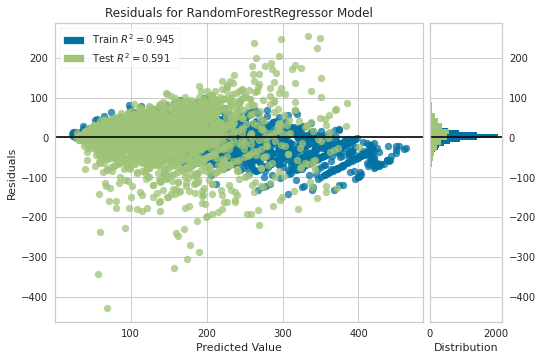

In [72]:
X_w_rand_train, X_w_rand_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_2 = ResidualsPlot(RandomForestRegressor())
visualizer_2.fit(X_w_rand_train, y_train)
visualizer_2.score(X_w_rand_test, y_test)
visualizer_2.show()

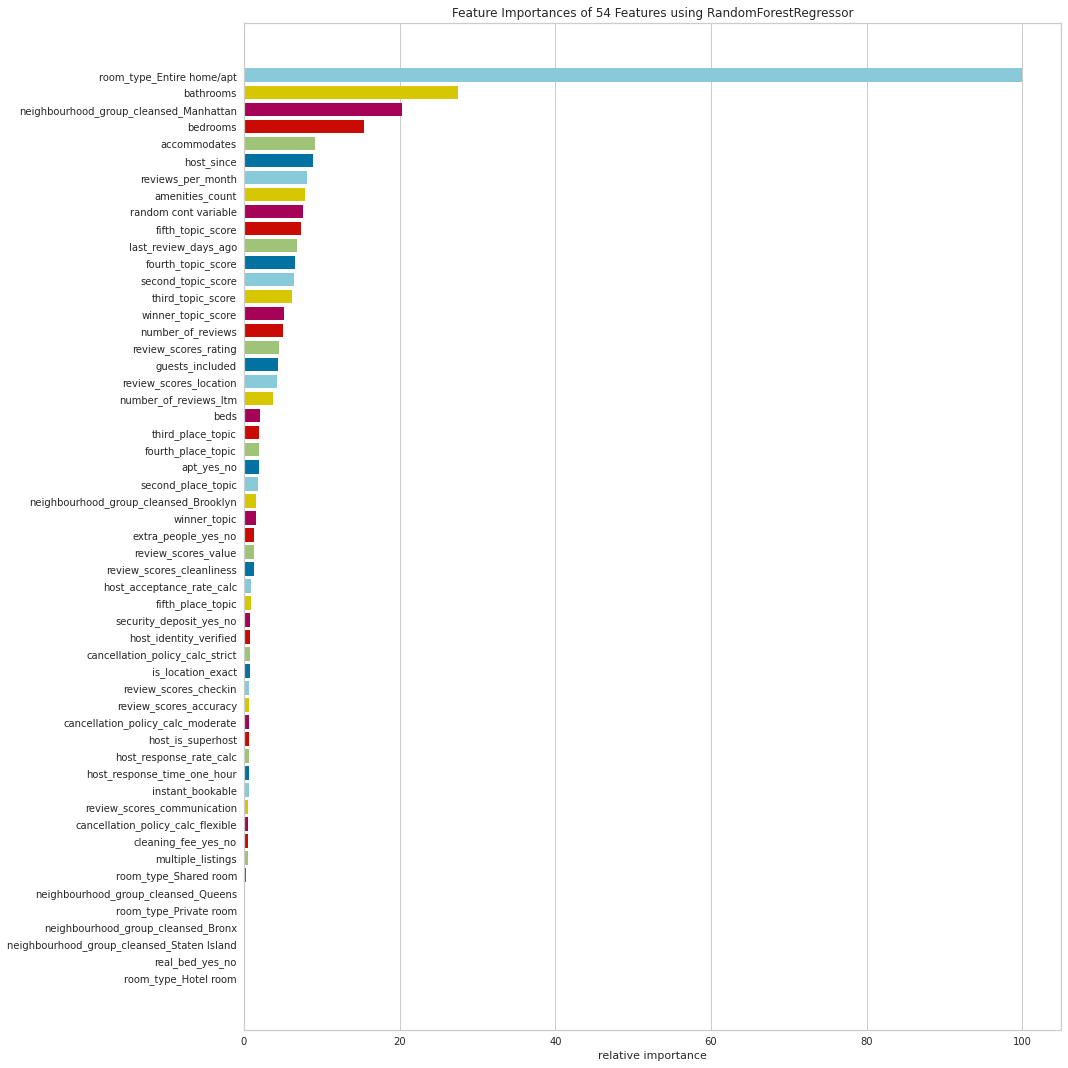

In [73]:
# Most important features
features_w_rand = features.append('random variable')
viz = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1080, 1080))
viz.fit(X_w_rand_train, y_train)
viz.show()

In [74]:
# X['neighbourhood_group_cleansed_Manhattan'].value_counts()
# X['neighbourhood_group_cleansed_Brooklyn'].value_counts()
# X['host_since'].value_counts()
# X['last_review_days_ago'].value_counts()

In [75]:
# X.columns

### Running the ensemble base model Random Forest removing room_type_Entire home/apt

In [76]:
X_not_prop_type = X.loc[:, X.columns != 'room_type_Entire home/apt']

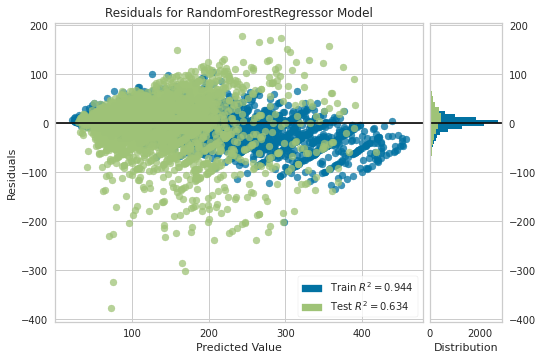

In [77]:
X_not_prop_type_train, X_not_prop_test, y_train, y_test = train_test_split(X_not_prop_type, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_3 = ResidualsPlot(RandomForestRegressor())
visualizer_3.fit(X_not_prop_type_train, y_train)
visualizer_3.score(X_not_prop_test, y_test)
visualizer_3.show()

In [78]:
# Most important features
features_not_property_typ = features.remove('room_type_Entire home/apt')

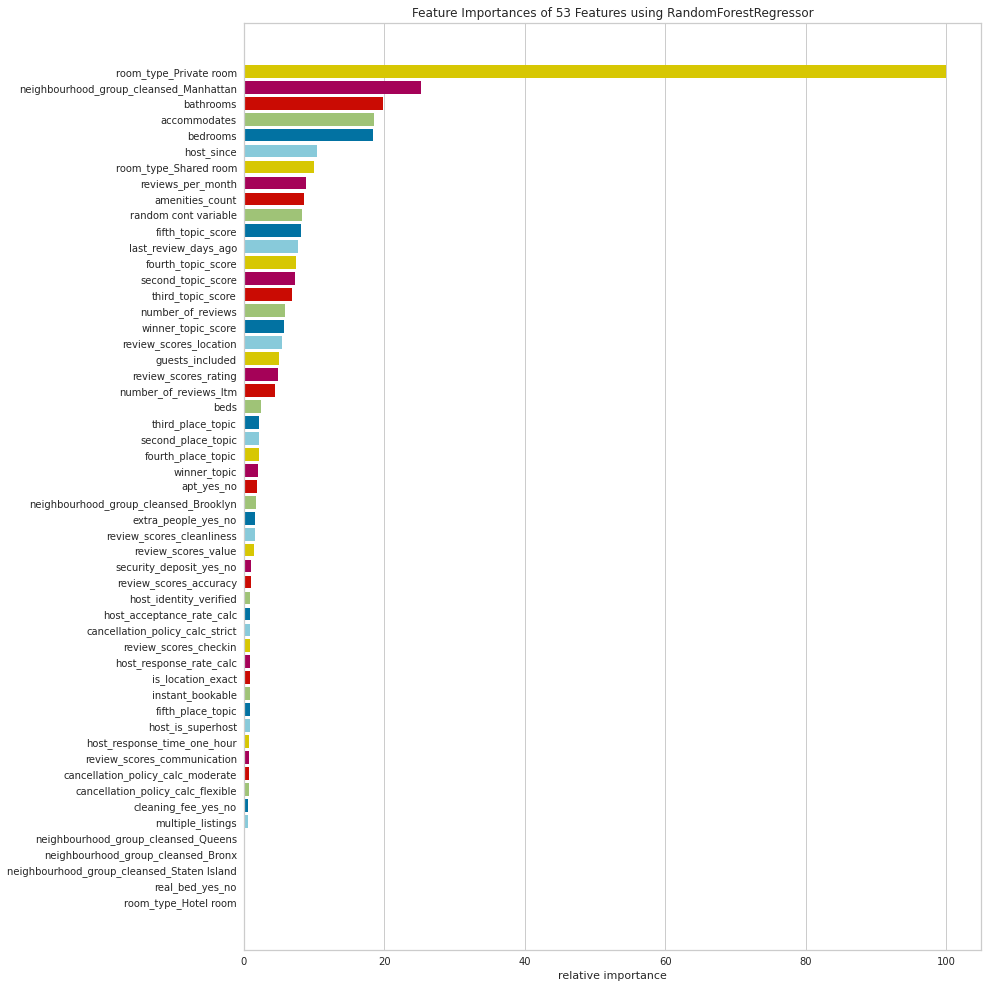

In [79]:
viz_3 = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1000, 1000))
viz_3.fit(X_not_prop_type_train, y_train)
viz_3.show()

### Determining linearity between room type entire home/apt

In [80]:
df_col = pd.DataFrame()
df_col['room type'] = X['room_type_Entire home/apt']
df_col['price'] = y

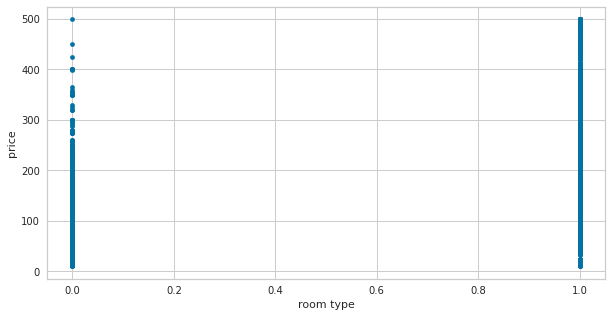

In [81]:
df_col.plot(kind='scatter', x='room type', y='price', figsize=(10,5), grid=True)
# X.plot(kind='scatter', x=X['room_type_Entire home/apt'], y=y, figsize=(10,5), grid=True)

In [83]:
# filepath = '5_text_analysis_name_desc.db'
# dill.dump_session()
# dill.load_session(filepath)